In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import csv

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import Draw

# 1. Datasets generation

## 1.1 Corpus-augmented approach

### From the data retrieved, let's clean the data and prepare a prompt for GPT-4

In [545]:
df_corpus_aug = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/Reaxys_Exp_test1.xlsx')

In [125]:
df_corpus_aug.shape

(1871, 17)

In [546]:
df_corpus_aug_cleaned = df_corpus_aug.dropna(subset=['reaction_procedure'])

df_corpus_aug_cleaned = df_corpus_aug.dropna(subset=['product'])


df_corpus_aug_cleaned = df_corpus_aug_cleaned[df_cleaned['reaction_procedure'].str.strip() != '']

df_corpus_aug_cleaned = df_corpus_aug_cleaned[df_cleaned['product'].str.strip() != '']

df_corpus_aug_cleaned.to_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/corpus_aug_dataset.xlsx', index=False)

df_corpus_aug_cleaned.shape

(1719, 17)

In [128]:
df_corpus_aug_cleaned.fillna('unknown', inplace=True)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_79909/45259008.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_corpus_aug_cleaned.fillna('unknown', inplace=True)


In [129]:
def create_prompt(row):
    return f"Predict the product for the following reaction: First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}, Temperature: {row['Temperature_C']}°C, Time: {row['Time_h']} hours, Catalyst: {row['Catalyst']}, Solvent: {row['Solvent (Reaction Details)']}. Also the procedure of the reaction was the following: {row['reaction_procedure']}"

In [547]:
df_mc = pd.DataFrame()

df_mc['prompt'] = ''
df_mc['answer'] = ''
df_mc['qa_pair'] = ''

df_mc['prompt'] = df_corpus_aug_cleaned.apply(create_prompt, axis=1)

df_mc['answer'] = df_corpus_aug_cleaned['product']

df_mc['qa_pair'] = df_mc['prompt'] + " The SMILES answer is : " + df_mc['answer'] + "\n\n"

df_mc[['qa_pair']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_data_aug.txt', index=False, header=False, sep='\t')

In [133]:
df_mc.shape

(1719, 3)

In [548]:
training_data_mc = df_mc.sample(frac=0.8, random_state=42)

test_data_mc = df_mc.drop(training_data_mc.index)

training_data_mc.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_training_data_aug.txt', index=False, header=False)
test_data_mc.to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_test_data_aug.txt', index=False, header=False)

In [136]:
print(training_data_mc.shape, test_data_mc.shape)

(1375, 3) (344, 3)


# 1.2 Simple-corpus approach

In [549]:
df_corpus_simple = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/corpus_aug_dataset.xlsx')

In [259]:
df_corpus_simple.shape

(1719, 17)

In [260]:

df_corpus_simple = df_corpus_simple.drop_duplicates(subset=['reactant_1', 'reactant_2', 'product'], keep='first')

In [261]:
df_corpus_simple

,reactant_1,reactant_2,product,reactant_1.1,reactant_2.1,product.1,reaction_procedure,Time_h,Temperature_C,Pressure_Torr,pH,Other_Conditions,Reaction Type,Yield (numerical),Reagent,Catalyst,Solvent (Reaction Details)
0,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O,CC(=O)C1=CC=C(Cl)C=C1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,1-benzylisatin,para-chloroacetophenone,1-benzyl-3-(2-(4-chlorophenyl)-2-oxoethyl)-3-o...,"General procedure: Isatins (A) (see Scheme 1),...",6,24.84,NaN,NaN,NaN,Aldol Condensation,91.0,piperidine,NaN,ethanol
4,CCN(CC)C1=CC=C(C=O)C=C1,O=C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,4-Diethylaminobenzaldehyde,cyclopentanone,"2,5-bis(<4-(diethylamino)phenyl>methylene)cycl...",General procedure: 4-(Diethylamino)benzaldehyd...,24,20,NaN,NaN,NaN,NaN,98.0,sodium hydroxide,NaN,ethanol
6,O=C\C=C\C1=CC=CC=C1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=O,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,(E)-3-phenylpropenal,"(4R)-3-(4-pentenoyl)-4-(phenylmethyl)-1,3-oxa...","(4R)-3-[(2S,3S,4E)-3-hydroxy-5-phenyl-2-(2-pro...","Step B(4R)-3-[(2S, 3S, 4E)-3-hydroxy-5-phe nyl...",17,20,NaN,NaN,NaN,NaN,88.0,chloro-trimethyl-silane; sodium hexafluoroanti...,NaN,ethyl acetate
10,O=CC1=CC=CO1,CC(C)=O,CC(=O)C=CC1=CC=CO1,furfural,acetone,4-(furan-2-yl)but-3-en-2-one,Acetone and furfural were weighed in a total o...,10,50,NaN,NaN,Autoclave,Aldol Condensation,86.0,magnesium hydroxide,NaN,methanol; water
20,O=CC1=CNC2=C1C=CC=C2,CC(=O)C1=CC=C(C)C=C1,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,Indole-3-carboxaldehyde,para-methylacetophenone,(E)-3-(1H-indol-3-yl)-1-(p-tolyl)prop-2-en-1-one,"General procedure: In an RB flask, 1H-indole-3...",NaN,70,NaN,NaN,NaN,NaN,90.0,piperidine,NaN,ethanol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,O=CC1=CC=CS1,CC(=O)C1=CC=CC=C1,O=C(\C=C\C1=CC=CS1)C1=CC=CC=C1,thiophene-2-carbaldehyde,acetophenone,(E)-1-phenyl-3-(thiophen-2-yl)-2-propen-1-one,General procedure: In a 10 mL flask at 0 C was...,NaN,0,NaN,NaN,NaN,NaN,96.0,potassium hydroxide,NaN,methanol; water
1668,CC(=O)C1=CC=CO1,COC1=CC=C(C=O)C=C1,COC1=CC=C(\C=C\C(=O)C2=CC=CO2)C=C1,1-(2-furyl)-1-ethanone,4-methoxy-benzaldehyde,(E)-1-(furan-2-yl)-3-(4-methoxyphenyl)prop-2-e...,NaN,15,15 - 20,NaN,NaN,NaN,Claisen-Schmidt Condensation,90.0,sodium hydroxide,NaN,methanol; water
1679,O=C\C=C\C1=CC=CC=C1,CC(=O)C1=CC=CS1,O=C(\C=C\C=C\C1=CC=CC=C1)C1=CC=CS1,(E)-3-phenylpropenal,2-Acetylthiophene,"(2E,4E)-5-phenyl-1-(thiophen-2-yl)penta-2,4-di...",General procedure: All the compounds covered u...,16,5 - 20,NaN,NaN,Inert atmosphere,Claisen-Schmidt Condensation,95.0,sodium hydroxide,NaN,ethanol; water
1685,CC(=O)C1=CC=CS1,[H]C(=O)C1=CC=CC=C1,O=C(\C=C\C1=CC=CC=C1)C1=CC=CS1,2-Acetylthiophene,benzaldehyde,2-cinnamoylthiophene,"A mixture of 2-acetylthiophene (5.00 g, 39.63 ...",24,20,NaN,NaN,NaN,NaN,99.0,sodium hydroxide,NaN,water


In [262]:
df_corpus_simple.fillna('unknown', inplace=True)

In [551]:
def create_prompt_corpus(row):
    return f"Predict the product for the following reaction: First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}, Temperature: {row['Temperature_C']}°C, Time: {row['Time_h']} hours, Catalyst: {row['Catalyst']}, Solvent: {row['Solvent (Reaction Details)']}, pH: {row['pH']}, Other Conditions: {row['Other_Conditions']}, Yield: {row['Yield (numerical)']}. Also the procedure of the reaction was the following: {row['reaction_procedure']}"


In [552]:
#Preparing the dataset for prompt - answer in-context learning for simple corpus

df = pd.DataFrame()

df['prompt'] = ''
df['answer'] = ''
df['qa_pair'] = ''

df['prompt'] = df_corpus_simple.apply(create_prompt, axis=1)

df['answer'] = df_corpus_simple['product']

df['qa_pair'] = df['prompt'] + "\n" " The SMILES answer is : " + df['answer'] + "\n\n"

df[['qa_pair']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_data_simple.txt', index=False, header=False, sep='\t')


In [553]:
training_data_simple = df.sample(frac=0.8, random_state=42)

test_data_simple = df.drop(training_data_simple.index)

training_data_simple['qa_pair'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_training_data_simple.txt', index=False, header=False)
test_data_simple['prompt'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_test_data_simple.txt', index=False, header=False)

## 1.3 Conditions approach

### In this case, we will add a few other variables to provide more information about the context in which the reaction happens

In [554]:
df_cond = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/corpus_aug_dataset.xlsx')

In [384]:
def create_prompt_cond(row):
    return f"Predict the product for the following reaction: First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}, Temperature: {row['Temperature_C']}°C, Time: {row['Time_h']} hours, Catalyst: {row['Catalyst']}, Solvent: {row['Solvent (Reaction Details)']}, pH: {row['pH']}, Other Conditions: {row['Other_Conditions']}, Yield: {row['Yield (numerical)']}." 


In [382]:
df_cond.fillna('unknown', inplace=True)

/var/folders/g8/mq_cbywj17g7tbgmmcy_bxm40000gn/T/ipykernel_79909/4065455942.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_cond.fillna('unknown', inplace=True)


In [389]:
df_cond = df_cond.drop_duplicates(subset=['reactant_1', 'reactant_2', 'product'], keep='first')

In [390]:
df_cond

,reactant_1,reactant_2,product,reactant_1.1,reactant_2.1,product.1,reaction_procedure,Time_h,Temperature_C,Pressure_Torr,pH,Other_Conditions,Reaction Type,Yield (numerical),Reagent,Catalyst,Solvent (Reaction Details)
0,O=C1N(CC2=CC=CC=C2)C2=CC=CC=C2C1=O,CC(=O)C1=CC=C(Cl)C=C1,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,1-benzylisatin,para-chloroacetophenone,1-benzyl-3-(2-(4-chlorophenyl)-2-oxoethyl)-3-o...,"General procedure: Isatins (A) (see Scheme 1),...",6,24.84,unknown,unknown,unknown,Aldol Condensation,91.0,piperidine,unknown,ethanol
4,CCN(CC)C1=CC=C(C=O)C=C1,O=C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,4-Diethylaminobenzaldehyde,cyclopentanone,"2,5-bis(<4-(diethylamino)phenyl>methylene)cycl...",General procedure: 4-(Diethylamino)benzaldehyd...,24,20,unknown,unknown,unknown,unknown,98.0,sodium hydroxide,unknown,ethanol
6,O=C\C=C\C1=CC=CC=C1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=O,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,(E)-3-phenylpropenal,"(4R)-3-(4-pentenoyl)-4-(phenylmethyl)-1,3-oxa...","(4R)-3-[(2S,3S,4E)-3-hydroxy-5-phenyl-2-(2-pro...","Step B(4R)-3-[(2S, 3S, 4E)-3-hydroxy-5-phe nyl...",17,20,unknown,unknown,unknown,unknown,88.0,chloro-trimethyl-silane; sodium hexafluoroanti...,unknown,ethyl acetate
10,O=CC1=CC=CO1,CC(C)=O,CC(=O)C=CC1=CC=CO1,furfural,acetone,4-(furan-2-yl)but-3-en-2-one,Acetone and furfural were weighed in a total o...,10,50,unknown,unknown,Autoclave,Aldol Condensation,86.0,magnesium hydroxide,unknown,methanol; water
20,O=CC1=CNC2=C1C=CC=C2,CC(=O)C1=CC=C(C)C=C1,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,Indole-3-carboxaldehyde,para-methylacetophenone,(E)-3-(1H-indol-3-yl)-1-(p-tolyl)prop-2-en-1-one,"General procedure: In an RB flask, 1H-indole-3...",unknown,70,unknown,unknown,unknown,unknown,90.0,piperidine,unknown,ethanol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,O=CC1=CC=CS1,CC(=O)C1=CC=CC=C1,O=C(\C=C\C1=CC=CS1)C1=CC=CC=C1,thiophene-2-carbaldehyde,acetophenone,(E)-1-phenyl-3-(thiophen-2-yl)-2-propen-1-one,General procedure: In a 10 mL flask at 0 C was...,unknown,0,unknown,unknown,unknown,unknown,96.0,potassium hydroxide,unknown,methanol; water
1668,CC(=O)C1=CC=CO1,COC1=CC=C(C=O)C=C1,COC1=CC=C(\C=C\C(=O)C2=CC=CO2)C=C1,1-(2-furyl)-1-ethanone,4-methoxy-benzaldehyde,(E)-1-(furan-2-yl)-3-(4-methoxyphenyl)prop-2-e...,unknown,15,15 - 20,unknown,unknown,unknown,Claisen-Schmidt Condensation,90.0,sodium hydroxide,unknown,methanol; water
1679,O=C\C=C\C1=CC=CC=C1,CC(=O)C1=CC=CS1,O=C(\C=C\C=C\C1=CC=CC=C1)C1=CC=CS1,(E)-3-phenylpropenal,2-Acetylthiophene,"(2E,4E)-5-phenyl-1-(thiophen-2-yl)penta-2,4-di...",General procedure: All the compounds covered u...,16,5 - 20,unknown,unknown,Inert atmosphere,Claisen-Schmidt Condensation,95.0,sodium hydroxide,unknown,ethanol; water
1685,CC(=O)C1=CC=CS1,[H]C(=O)C1=CC=CC=C1,O=C(\C=C\C1=CC=CC=C1)C1=CC=CS1,2-Acetylthiophene,benzaldehyde,2-cinnamoylthiophene,"A mixture of 2-acetylthiophene (5.00 g, 39.63 ...",24,20,unknown,unknown,unknown,unknown,99.0,sodium hydroxide,unknown,water


In [555]:
df_c = pd.DataFrame()

df_c['prompt'] = df_cond.apply(create_prompt_cond, axis=1)
df_c['answer'] = df_cond['product']

df_c['qa_pair'] = df_c['prompt'].str.strip() + "\n" + "The SMILES answer is: " + df_c['answer'].str.strip() + "\n\n"

df_c[['qa_pair']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_data_cond.txt', index=False, header=False, sep='\t')

In [556]:
training_data_cond = df_c.sample(frac=0.8, random_state=42)

test_data_cond_qa = df_c.drop(training_data_cond.index)

training_data_cond['qa_pair'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_training_data_cond.txt', index=False, header=False)
test_data_cond_qa['prompt'].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_test_data_cond_q.txt', index=False, header=False, sep='\t', quoting=csv.QUOTE_NONE, escapechar='\n')

## 1.4 SMILES only approach

### Just to have a set for comparison, between augmented prompt-data and purely SMILES-based data

In [557]:
df_smiles = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/corpus_aug_dataset.xlsx')

In [317]:
df_smiles.shape

(1719, 17)

In [318]:
df_smiles = df_smiles.drop_duplicates(subset=['reactant_1', 'reactant_2', 'product'], keep='first')

In [319]:
df_smiles.shape

(97, 17)

In [320]:
df_smiles = df_smiles.iloc[:, :3]

In [321]:
def create_prompt_smiles(row):
    return f"Predict the product for the following reaction: First reactant: {row['reactant_1']}, second reactant: {row['reactant_2']}"


In [558]:
df_s = pd.DataFrame()

df_s['prompt'] = ''
df_s['answer'] = ''
df_s['qa_pair'] = ''

df_s['prompt'] = df_smiles.apply(create_prompt_smiles, axis=1)

df_s['answer'] = df_smiles['product']

df_s['qa_pair'] = df_s['prompt'] + " The SMILES answer is : " + df_s['answer'] + "\n\n"

df_s[['qa_pair']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_data_smiles.txt', index=False, header=False, sep='\t')

In [559]:
df_s = pd.DataFrame()

df_s['prompt'] = df_smiles.apply(create_prompt_smiles, axis=1)
df_s['answer'] = df_smiles['product']

df_s['qa_pair'] = df_s['prompt'].str.strip() + "\n" + "The SMILES answer is: " + df_s['answer'].str.strip() + "\n\n"

df_s[['qa_pair']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_data_smiles.txt', index=False, header=False, sep='\t')

In [324]:
df_s

,prompt,answer,qa_pair
0,Predict the product for the following reaction...,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,Predict the product for the following reaction...
4,Predict the product for the following reaction...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,Predict the product for the following reaction...
6,Predict the product for the following reaction...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,Predict the product for the following reaction...
10,Predict the product for the following reaction...,CC(=O)C=CC1=CC=CO1,Predict the product for the following reaction...
20,Predict the product for the following reaction...,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,Predict the product for the following reaction...
...,...,...,...
1641,Predict the product for the following reaction...,O=C(\C=C\C1=CC=CS1)C1=CC=CC=C1,Predict the product for the following reaction...
1668,Predict the product for the following reaction...,COC1=CC=C(\C=C\C(=O)C2=CC=CO2)C=C1,Predict the product for the following reaction...
1679,Predict the product for the following reaction...,O=C(\C=C\C=C\C1=CC=CC=C1)C1=CC=CS1,Predict the product for the following reaction...
1685,Predict the product for the following reaction...,O=C(\C=C\C1=CC=CC=C1)C1=CC=CS1,Predict the product for the following reaction...


In [560]:
training_data_smiles = df_s.sample(frac=0.8, random_state=42)

test_data_smiles_qa = df_s.drop(training_data_smiles.index)

training_data_smiles[['qa_pair']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_training_data_smiles.txt', index=False, header=False, sep='\t')

test_data_smiles_qa[['prompt']].to_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/prompt_test_data_smiles_q.txt', index=False, header=False, sep='\t')

# 2. Tamonimoto Similarity SMILES check

## In this part, the Tanimoto metric will be calculated to access the similarity between the true and predicted SMILES

## 2.1 Function definitions

In [252]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors

In [255]:
def smiles_to_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES: {smiles}")
            return None
    
        generator = rdMolDescriptors.GetMorganFingerprintAsBitVect
        fingerprint = generator(mol, radius=2, nBits=2048)
        
        return fingerprint
    except Exception as e:
        print(f"Error generating fingerprint for {smiles}: {e}")
        return None

def compute_tanimoto(smiles_pred, smiles_true):
    fp1 = smiles_to_fingerprint(smiles_pred)
    fp2 = smiles_to_fingerprint(smiles_true)
    
    if fp1 is None or fp2 is None:
        return None
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [360]:
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None  
    except:
        return False  

def filter_invalid_smiles(df, smiles_column='SMILES_pred'):

    df_filtered = df[df[smiles_column].apply(is_valid_smiles)]
    
    return df_filtered

In [419]:
def tanim_avg(df):

    total = 0
    count = 0

    for i in df.iloc[:,2]:
        total += i
        count += 1
    
    return total/count

### 2.2 SMILES only with priming

In [561]:
df_gpt4_pred = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/SMILES_pred_SMILESONLYtest.xlsx')

df_smiles_tanim = pd.DataFrame()

df_smiles_tanim['SMILES_pred'] = df_gpt4_pred['SMILES_pred']

test_data_smiles_qa.reset_index(drop=True, inplace=True)
df_smiles_tanim['SMILES_true'] = test_data_smiles_qa.iloc[:,1]

In [497]:
df_smiles_tanim

,SMILES_pred,SMILES_true
0,CCN(CC)C1=CC=C(C=C2CCC3=CC=CC=C3C2=O)C=C1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
1,O=C(CCC\C=C\C1=CC=CC=C1)N1[C@H](CC2=CC=CC=C2)C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
2,CC(=O)C1=CC=C(Cl)C=C1C(=O)C2=NC3=CC=CC=C3N2,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2
3,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O
4,[H][C@@]1(CCCCC1=O)[C@H](O)C1=CC=C(C=C1N(=O)=O...,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...
5,CC(C)=CC(=O)C1=CC=C(O1)C=O,CC(C)CC(=O)C=CC1=CC=C(CO)O1
6,O=C(C=CC1=CC=CS1)C1=CC=CC(=C1)N(=O)=O,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O
7,O=C(F)C1=CC=CC=C1C(=O)C2=CC=CC=C2O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1
8,FC1=CC=C(C=C2C=CC(=O)C=C2C=O)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1
9,BrC1=CC=C(Br)C(=O)C2=CC=C(C=C2)C=O,BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1


In [498]:
df_smiles_tanim_filtered = filter_invalid_smiles(df_smiles_tanim, 'SMILES_pred')

[11:31:42] SMILES Parse Error: unclosed ring for input: 'BrC1=CC=C(Br)C(=O)C2=CC=C(C=C2)C=O'
[11:31:42] SMILES Parse Error: unclosed ring for input: 'ClC1=CC=C(C=C2C=NC3=CC=CC=C3N2)C=O'


In [499]:
df_smiles_tanim_filtered

,SMILES_pred,SMILES_true
0,CCN(CC)C1=CC=C(C=C2CCC3=CC=CC=C3C2=O)C=C1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
1,O=C(CCC\C=C\C1=CC=CC=C1)N1[C@H](CC2=CC=CC=C2)C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
2,CC(=O)C1=CC=C(Cl)C=C1C(=O)C2=NC3=CC=CC=C3N2,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2
3,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O
4,[H][C@@]1(CCCCC1=O)[C@H](O)C1=CC=C(C=C1N(=O)=O...,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...
5,CC(C)=CC(=O)C1=CC=C(O1)C=O,CC(C)CC(=O)C=CC1=CC=C(CO)O1
6,O=C(C=CC1=CC=CS1)C1=CC=CC(=C1)N(=O)=O,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O
7,O=C(F)C1=CC=CC=C1C(=O)C2=CC=CC=C2O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1
8,FC1=CC=C(C=C2C=CC(=O)C=C2C=O)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1
10,O=C1CCC2=CC=CC=C2C1C1=CC=C(C=C1)N(=O)=O,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O


In [500]:
df_smiles_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_smiles_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)

[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerator
[11:31:47] DEPRECATION WARNING: please use MorganGenerat

In [501]:
df_smiles_tanim_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCC3=CC=CC=C3C2=O)C=C1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.717949
1,O=C(CCC\C=C\C1=CC=CC=C1)N1[C@H](CC2=CC=CC=C2)C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.531250
2,CC(=O)C1=CC=C(Cl)C=C1C(=O)C2=NC3=CC=CC=C3N2,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2,0.250000
3,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,1.000000
4,[H][C@@]1(CCCCC1=O)[C@H](O)C1=CC=C(C=C1N(=O)=O...,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...,1.000000
5,CC(C)=CC(=O)C1=CC=C(O1)C=O,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.250000
6,O=C(C=CC1=CC=CS1)C1=CC=CC(=C1)N(=O)=O,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,1.000000
7,O=C(F)C1=CC=CC=C1C(=O)C2=CC=CC=C2O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.394737
8,FC1=CC=C(C=C2C=CC(=O)C=C2C=O)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,0.255319
10,O=C1CCC2=CC=CC=C2C1C1=CC=C(C=C1)N(=O)=O,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O,0.351852


In [502]:
tanim_avg(df_smiles_tanim_filtered)

0.5460908120357314

### 2.2 SMILES only no priming


In [562]:
df_gpt4_pred = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/SMILES_pred_SMILESONLYtest__nopriming.xlsx')

df_smiles_tanim_np = pd.DataFrame()

df_smiles_tanim_np['SMILES_pred'] = df_gpt4_pred['SMILES_pred']

test_data_smiles_qa.reset_index(drop=True, inplace=True)
df_smiles_tanim_np['SMILES_true'] = test_data_smiles_qa.iloc[:,1]

In [504]:
df_smiles_tanim_filtered_np = filter_invalid_smiles(df_smiles_tanim_np, 'SMILES_pred')

In [505]:
df_smiles_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_smiles_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerator
[11:32:00] DEPRECATION WARNING: please use MorganGenerat

In [506]:
df_smiles_tanim_filtered_np

,SMILES_pred,SMILES_true,tanimoto_similarity
0,CCN(CC)C1=CC=C(\C=C\C(=O)C2CCCCC2)C=C1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.413043
1,O=C(\C=C\C1=CC=CC=C1)C=CCCC(=O)N1[C@H](CC2=CC=...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.515152
2,O=C(\C=C\C1=CC=C(Cl)C=C1)C1=CNC2=CC=CC=C12,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2,0.600000
3,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,1.000000
4,[H][C@@]1(CCCCC1=O)[C@H](O)C1=CC=C(C=C1N(=O)=O...,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...,1.000000
5,OCC1=CC=C(O1)\C=C\C(=O)C(C)C,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.684211
6,O=C(\C=C\C1=CC=CS1)C1=CC=C(C=C1)N(=O)=O,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,0.738095
7,FC1=CC=C(\C=C\C(=O)C2=C(O)C=CC=C2)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.621622
8,FC1=CC=C(\C=C\C(=O)C2=C(O)C=CC=C2)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,1.000000
9,BrC1=CC=C(\C=C\C(=O)C2=CC=C(Br)C=C2)C=C1,BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1,1.000000


In [507]:
tanim_avg(df_smiles_tanim_filtered_np)

0.7377695264352231

### 2.3 SMILES & Conditions no priming


In [563]:
df_gpt4_pred = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/SMILES_pred_cond_nopriming.xlsx')

df_cond_tanim_np = pd.DataFrame()

df_cond_tanim_np['SMILES_pred'] = df_gpt4_pred['SMILES_pred']

test_data_cond_qa.reset_index(drop=True, inplace=True)
df_cond_tanim_np['SMILES_true'] = test_data_cond_qa.iloc[:,1]

In [509]:
df_cond_tanim

,SMILES_pred,SMILES_true
0,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=C/CC=C/C1=...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
2,CC(=O)C1=CC=C(Cl)C=C1C=CC=C1CNC2=CC=CC=C12,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2
3,CCOC(=O)C(=N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O
4,O=C1CCCCC1C=C1C=CC=C(C=N=O)C1,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...
5,CC(C)CC(=O)C=CC1=CC=CO1,CC(C)CC(=O)C=CC1=CC=C(CO)O1
6,CC(=O)C1=CC=CC(N=O)=C1C=C/CC=C/S,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O
7,FC1=CC=C(C=C1)C=O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1
8,FC1=CC=C(C=O)C=C1C(=O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1
9,BrC1=CC=C(Br)C=C1C=CC=C(C=O),BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1


In [564]:
df_cond_tanim_filtered_np = filter_invalid_smiles(df_cond_tanim, 'SMILES_pred')

[13:37:00] Explicit valence for atom # 14 N, 4, is greater than permitted


In [511]:
df_cond_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_cond_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerator
[11:32:15] DEPRECATION WARNING: please use MorganGenerat

In [512]:
df_cond_tanim_filtered_np

,SMILES_pred,SMILES_true,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.372093
1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=C/CC=C/C1=...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.478261
2,CC(=O)C1=CC=C(Cl)C=C1C=CC=C1CNC2=CC=CC=C12,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2,0.246154
3,CCOC(=O)C(=N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,0.666667
5,CC(C)CC(=O)C=CC1=CC=CO1,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.560976
6,CC(=O)C1=CC=CC(N=O)=C1C=C/CC=C/S,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,0.156250
7,FC1=CC=C(C=C1)C=O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.179487
8,FC1=CC=C(C=O)C=C1C(=O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,0.304348
9,BrC1=CC=C(Br)C=C1C=CC=C(C=O),BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1,0.250000
10,C1=CC=C(C=C1)C=CC=CC(=O)C1CCCCC1,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O,0.166667


In [513]:
tanim_avg(df_cond_tanim_filtered_np)

0.33827459169732177

### 2.4 SMILES & Conditions with priming

In [565]:
df_gpt4_pred = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/SMILES_pred_cond_priming.xlsx')

df_cond_tanim = pd.DataFrame()

df_cond_tanim['SMILES_pred'] = df_gpt4_pred['SMILES_pred']

test_data_cond_qa.reset_index(drop=True, inplace=True)
df_cond_tanim['SMILES_true'] = test_data_cond_qa.iloc[:,1]

In [515]:
df_cond_tanim

,SMILES_pred,SMILES_true
0,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=C/CC=C/C1=...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
2,CC(=O)C1=CC=C(Cl)C=C1C=CC=C1CNC2=CC=CC=C12,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2
3,CCOC(=O)C(=N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O
4,O=C1CCCCC1C=C1C=CC=C(C=N=O)C1,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...
5,CC(C)CC(=O)C=CC1=CC=CO1,CC(C)CC(=O)C=CC1=CC=C(CO)O1
6,CC(=O)C1=CC=CC(N=O)=C1C=C/CC=C/S,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O
7,FC1=CC=C(C=C1)C=O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1
8,FC1=CC=C(C=O)C=C1C(=O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1
9,BrC1=CC=C(Br)C=C1C=CC=C(C=O),BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1


In [516]:
df_cond_tanim_filtered = filter_invalid_smiles(df_cond_tanim, 'SMILES_pred')

[11:32:27] Explicit valence for atom # 14 N, 4, is greater than permitted


In [517]:
df_cond_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_cond_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)


[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerator
[11:32:30] DEPRECATION WARNING: please use MorganGenerat

In [518]:
df_cond_tanim_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C1)C(=O)C1CCCC1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.372093
1,C=CCCC(=O)N1[C@H](CC2=CC=CC=C2)COC1=C/CC=C/C1=...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.478261
2,CC(=O)C1=CC=C(Cl)C=C1C=CC=C1CNC2=CC=CC=C12,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2,0.246154
3,CCOC(=O)C(=N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,0.666667
5,CC(C)CC(=O)C=CC1=CC=CO1,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.560976
6,CC(=O)C1=CC=CC(N=O)=C1C=C/CC=C/S,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,0.156250
7,FC1=CC=C(C=C1)C=O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.179487
8,FC1=CC=C(C=O)C=C1C(=O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,0.304348
9,BrC1=CC=C(Br)C=C1C=CC=C(C=O),BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1,0.250000
10,C1=CC=C(C=C1)C=CC=CC(=O)C1CCCCC1,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O,0.166667


In [519]:
tanim_avg(df_cond_tanim_filtered)

0.33827459169732177

### 2.5 SMILES & Conditions & Corpus no priming

In [520]:
df_gpt4_pred = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/SMILES_pred_corpus_no_priming.xlsx')

df_simple_tanim_np = pd.DataFrame()

df_simple_tanim_np['SMILES_pred'] = df_gpt4_pred['SMILES_pred']

test_data_simple.reset_index(drop=True, inplace=True)
df_simple_tanim_np['SMILES_true'] = test_data_simple.iloc[:,1]

In [521]:
df_simple_tanim_np

,SMILES_pred,SMILES_true
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
2,OC@@HC@HC(=O)N1C@HCOC1=O,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2
3,CC(=O)C=CC1=CC=CO1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O
4,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...
5,CCOC(=O)C(=C\C1=CC=C(O)C=C1)\C#N,CC(C)CC(=O)C=CC1=CC=C(CO)O1
6,COC1=CC(O)=C(C=C1)C(=O)\C=C\C(=O)\C=C\C2=CC(O)...,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O
7,COC1=CC=C(\C=C\C(=O)C2=CC(OC)=C(OC)C=C2)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1
8,CCOC(=O)C(=[N]#N)C(O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1
9,BrC1=CC=C(\C=C\C(=O)C2=CC=C(Br)C=C2)C=C1,BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1


In [522]:
df_simple_tanim_filtered_np = filter_invalid_smiles(df_simple_tanim_np, 'SMILES_pred')

[11:32:42] SMILES Parse Error: syntax error while parsing: OC@@HC@HC(=O)N1C@HCOC1=O
[11:32:42] SMILES Parse Error: Failed parsing SMILES 'OC@@HC@HC(=O)N1C@HCOC1=O' for input: 'OC@@HC@HC(=O)N1C@HCOC1=O'
[11:32:42] SMILES Parse Error: syntax error while parsing: [H][C@@]1(CCCCC1=O)C@HC1=CC=CC(=C1)N(=O)=O
[11:32:42] SMILES Parse Error: Failed parsing SMILES '[H][C@@]1(CCCCC1=O)C@HC1=CC=CC(=C1)N(=O)=O' for input: '[H][C@@]1(CCCCC1=O)C@HC1=CC=CC(=C1)N(=O)=O'
[11:32:42] SMILES Parse Error: syntax error while parsing: [H][C@@]1(CCCCC1=O)C@HC1=CC=C(C=C1)C#N
[11:32:42] SMILES Parse Error: Failed parsing SMILES '[H][C@@]1(CCCCC1=O)C@HC1=CC=C(C=C1)C#N' for input: '[H][C@@]1(CCCCC1=O)C@HC1=CC=C(C=C1)C#N'


In [523]:
df_simple_tanim_filtered_np.loc[:, 'tanimoto_similarity'] = df_simple_tanim_filtered_np.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)
df_simple_tanim_filtered_np

[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerator
[11:32:45] DEPRECATION WARNING: please use MorganGenerat

,SMILES_pred,SMILES_true,tanimoto_similarity
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.092308
1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.125000
3,CC(=O)C=CC1=CC=CO1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,0.122807
4,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...,0.070423
5,CCOC(=O)C(=C\C1=CC=C(O)C=C1)\C#N,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.157895
6,COC1=CC(O)=C(C=C1)C(=O)\C=C\C(=O)\C=C\C2=CC(O)...,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,0.159420
7,COC1=CC=C(\C=C\C(=O)C2=CC(OC)=C(OC)C=C2)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.207547
8,CCOC(=O)C(=[N]#N)C(O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,0.145455
9,BrC1=CC=C(\C=C\C(=O)C2=CC=C(Br)C=C2)C=C1,BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1,1.000000
10,O=C1CC(OC2=CC=CC=C12)C1=CC=C(C=C1)N(=O)=O,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O,0.293103


In [524]:
tanim_avg(df_simple_tanim_filtered_np)

0.21615056842208658

### 2.6 SMILES & Conditions & Corpus with priming

In [566]:
df_gpt4_pred = pd.read_excel('/Users/davidsegura/git/Leveraging_LLMs_causality/data_test_set_20/SMILES_pred_corpus_priming.xlsx')

df_simple_tanim = pd.DataFrame()

df_simple_tanim['SMILES_pred'] = df_gpt4_pred['SMILES_pred']

test_data_simple.reset_index(drop=True, inplace=True)
df_simple_tanim['SMILES_true'] = test_data_simple.iloc[:,1]

In [526]:
df_simple_tanim

,SMILES_pred,SMILES_true
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...
1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...
2,OC@@HC@HC(=O)N1C@HCOC1=O,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2
3,CC(=O)C=CC1=CC=CO1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O
4,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...
5,CCOC(=O)C(=C\C1=CC=C(O)C=C1)\C#N,CC(C)CC(=O)C=CC1=CC=C(CO)O1
6,COC1=C(O)C=CC(\C=C\C(=O)\C=C\C2=CC(OC)=C(O)C=C...,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O
7,COC1=CC=C(\C=C\C(=O)C2=CC(OC)=C(OC)C=C2)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1
8,CCOC(=O)C(=[N]#N)C(O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1
9,CCOC(=O)C(=[N]#N)C(O)C1CCCCC1,BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1


In [527]:
df_simple_tanim_filtered = filter_invalid_smiles(df_simple_tanim, 'SMILES_pred')

[11:32:55] SMILES Parse Error: syntax error while parsing: OC@@HC@HC(=O)N1C@HCOC1=O
[11:32:55] SMILES Parse Error: Failed parsing SMILES 'OC@@HC@HC(=O)N1C@HCOC1=O' for input: 'OC@@HC@HC(=O)N1C@HCOC1=O'


In [528]:
df_simple_tanim_filtered.loc[:, 'tanimoto_similarity'] = df_simple_tanim_filtered.apply(lambda row: compute_tanimoto(row['SMILES_pred'], row['SMILES_true']),axis=1)
df_simple_tanim_filtered

[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerator
[11:32:57] DEPRECATION WARNING: please use MorganGenerat

,SMILES_pred,SMILES_true,tanimoto_similarity
0,OC1(CC(=O)C2=CC=C(Cl)C=C2)C(=O)N(CC2=CC=CC=C2)...,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.092308
1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.125000
3,CC(=O)C=CC1=CC=CO1,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,0.122807
4,CC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=CC=CC=C12,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...,0.070423
5,CCOC(=O)C(=C\C1=CC=C(O)C=C1)\C#N,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.157895
6,COC1=C(O)C=CC(\C=C\C(=O)\C=C\C2=CC(OC)=C(O)C=C...,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,0.175439
7,COC1=CC=C(\C=C\C(=O)C2=CC(OC)=C(OC)C=C2)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.207547
8,CCOC(=O)C(=[N]#N)C(O)C1=CC=CC=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,0.145455
9,CCOC(=O)C(=[N]#N)C(O)C1CCCCC1,BrC1=CC=C(C=CC(=O)C2=CC=C(Br)C=C2)C=C1,0.055556
10,O=C1CC(OC2=CC=CC=C12)C1=CC=C(C=C1)N(=O)=O,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O,0.293103


In [529]:
tanim_avg(df_simple_tanim_filtered)

0.17525933238053523

### 2.6 SMILES & Conditions & Multi-Corpus

In [ ]:
df_aug_tanim = pd.read_excel()

df_aug_tanim['SMILES_pred'] = df_gpt4_pred['SMILES_pred']
df_aug_tanim['SMILES_true'] = df_corpus_aug_cleaned['product']

### 2.7 Tanimoto distribution plots

In [531]:
df_smiles_tanim_filtered

,SMILES_pred,SMILES_true,tanimoto_similarity
0,CCN(CC)C1=CC=C(C=C2CCC3=CC=CC=C3C2=O)C=C1,CCN(CC)C1=CC=C(C=C2CCC(=CC3=CC=C(C=C3)N(CC)CC)...,0.717949
1,O=C(CCC\C=C\C1=CC=CC=C1)N1[C@H](CC2=CC=CC=C2)C...,O[C@@H](\C=C\C1=CC=CC=C1)[C@H](CC=C)C(=O)N1[C@...,0.531250
2,CC(=O)C1=CC=C(Cl)C=C1C(=O)C2=NC3=CC=CC=C3N2,ClC1=CC=C(C=C1)C(=O)\C=C\C1=CNC2=C1C=CC=C2,0.250000
3,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,CCOC(=O)C(=[N]#N)C(O)C1=CC=C(C=C1)N(=O)=O,1.000000
4,[H][C@@]1(CCCCC1=O)[C@H](O)C1=CC=C(C=C1N(=O)=O...,[H][C@]1(CCCCC1=O)[C@@H](O)C1=C(C=C(C=C1)N(=O)...,1.000000
5,CC(C)=CC(=O)C1=CC=C(O1)C=O,CC(C)CC(=O)C=CC1=CC=C(CO)O1,0.250000
6,O=C(C=CC1=CC=CS1)C1=CC=CC(=C1)N(=O)=O,O=C(\C=C\C1=CC=CS1)C1=CC(=CC=C1)N(=O)=O,1.000000
7,O=C(F)C1=CC=CC=C1C(=O)C2=CC=CC=C2O,OC1=CC=CC=C1C(=O)\C=C\C1=C(F)C=CC=C1,0.394737
8,FC1=CC=C(C=C2C=CC(=O)C=C2C=O)C=C1,OC1=CC=CC=C1C(=O)\C=C\C1=CC=C(F)C=C1,0.255319
10,O=C1CCC2=CC=CC=C2C1C1=CC=C(C=C1)N(=O)=O,O=C1C(CCC2=CC=CC=C12)=CC1=CC=CC(=C1)N(=O)=O,0.351852


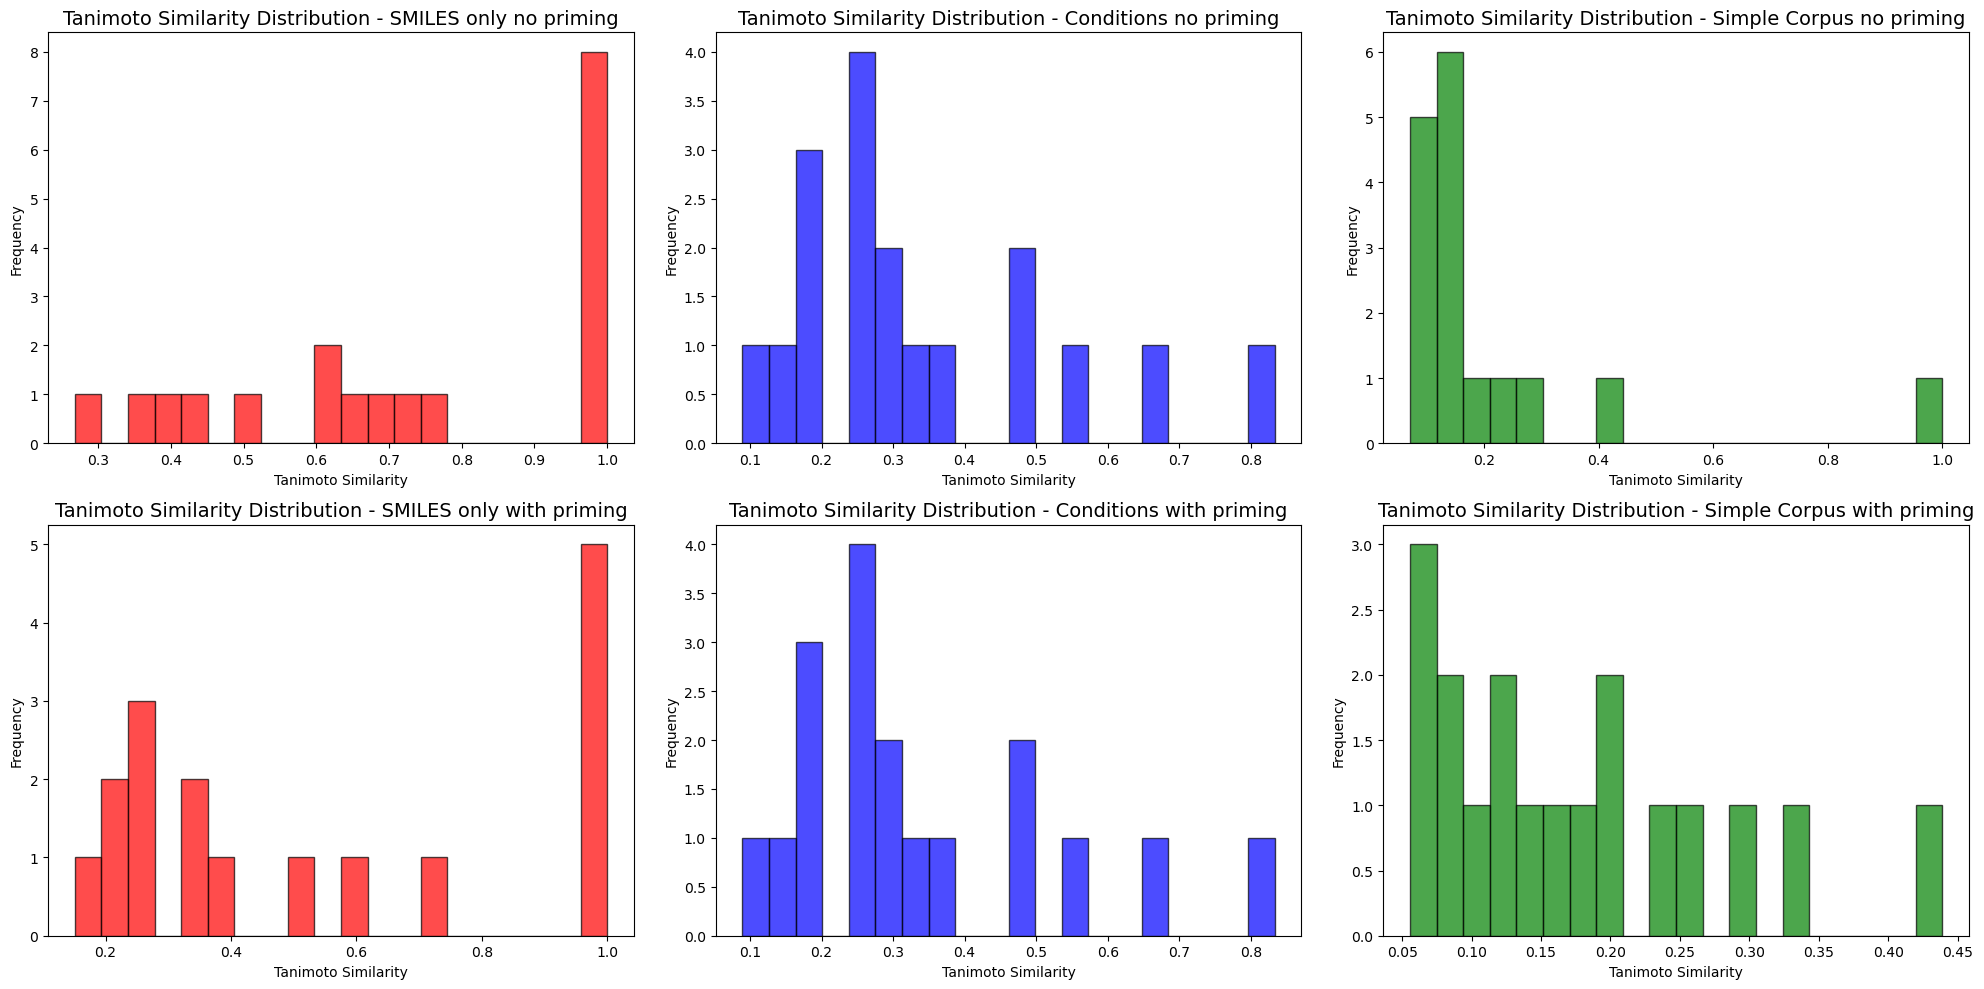

In [544]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].hist(df_smiles_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='red', edgecolor='black', alpha=0.7)
axs[0,0].set_title('Tanimoto Similarity Distribution - SMILES only no priming', fontsize=14)
axs[0,0].set_xlabel('Tanimoto Similarity')
axs[0,0].set_ylabel('Frequency')

axs[1,0].hist(df_smiles_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='red', edgecolor='black', alpha=0.7)
axs[1,0].set_title('Tanimoto Similarity Distribution - SMILES only with priming', fontsize=14)
axs[1,0].set_xlabel('Tanimoto Similarity')
axs[1,0].set_ylabel('Frequency')

axs[0,1].hist(df_cond_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='blue', edgecolor='black', alpha=0.7)
axs[0,1].set_title('Tanimoto Similarity Distribution - Conditions no priming', fontsize=14)
axs[0,1].set_xlabel('Tanimoto Similarity')
axs[0,1].set_ylabel('Frequency')

axs[1,1].hist(df_cond_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='blue', edgecolor='black', alpha=0.7)
axs[1,1].set_title('Tanimoto Similarity Distribution - Conditions with priming', fontsize=14)
axs[1,1].set_xlabel('Tanimoto Similarity')
axs[1,1].set_ylabel('Frequency')

axs[0,2].hist(df_simple_tanim_filtered_np['tanimoto_similarity'].dropna(), bins=20, color='green', edgecolor='black', alpha=0.7)
axs[0,2].set_title('Tanimoto Similarity Distribution - Simple Corpus no priming', fontsize=14)
axs[0,2].set_xlabel('Tanimoto Similarity')
axs[0,2].set_ylabel('Frequency')

axs[1,2].hist(df_simple_tanim_filtered['tanimoto_similarity'].dropna(), bins=20, color='green', edgecolor='black', alpha=0.7)
axs[1,2].set_title('Tanimoto Similarity Distribution - Simple Corpus with priming', fontsize=14)
axs[1,2].set_xlabel('Tanimoto Similarity')
axs[1,2].set_ylabel('Frequency')

plt.subplots_adjust(hspace = 20, wspace = -10**10)

plt.tight_layout()

plt.show()